# **Aspect-Based Sentiment Analysis on LGBTQ+ Tweets**
# **By 10909109, Prince Kojo Dugboryele**

In [4]:
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgbt-tweets/LGBT_Tweets_processed.csv


In [5]:
!pip install emoji

In [7]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
import seaborn as sns
from nltk.corpus import stopwords
import re
import string
import spacy
import nltk
import requests
import emoji
from bs4 import BeautifulSoup
import gensim
from gensim import corpora
from collections import Counter


In [8]:
data = pd.read_csv('/kaggle/input/lgbt-tweets/LGBT_Tweets_processed.csv')
data.head()

,Unnamed: 0,date,time,id,tweet,language,replies_count,retweets_count,likes_count
0,0,2022-08-26,10:31:10,1562991009180827649,Praying for my lgbt Nigerians 🙏🏽🙏🏽🙏🏽,en,0,0,0
1,1,2022-08-26,10:31:02,1562990976939229184,@yanmisamm So pass agg omg you really are lgbt,en,0,0,0
2,3,2022-08-26,10:30:59,1562990965442326528,@ChampionExcel @watokohom @MrAndyNgo @football...,en,0,0,0
3,7,2022-08-26,10:30:34,1562990860928659457,To be clear it doesn't justify what the LGBT c...,en,0,0,0
4,10,2022-08-26,10:30:24,1562990819485032449,good night lgbt community https://t.co/0PAMOU...,en,1,0,2


In [9]:
data.shape

(32456, 9)

In [10]:
df_data = pd.DataFrame(data['tweet'])
df_data

,tweet
0,Praying for my lgbt Nigerians 🙏🏽🙏🏽🙏🏽
1,@yanmisamm So pass agg omg you really are lgbt
2,@ChampionExcel @watokohom @MrAndyNgo @football...
3,To be clear it doesn't justify what the LGBT c...
4,good night lgbt community https://t.co/0PAMOU...
...,...
32451,@i664k @birdofterror4 @st1mmer @cringepolitik ...
32452,@Comrade4568 I`m anti-trans and anti-lgbt
32453,#Lgbt #lgbtq #lgbtqiaplus #lgbtqcommunity #lgb...
32454,Man its no fucking wonder why it's so hard for...


In [11]:
##Slangs Extraction and Removal

url = "https://messente.com/blog/text-abbreviations"
response = requests.get(url)


soup = BeautifulSoup(response.content, "html.parser")

b_tags = soup.find_all("b")
second_b_tag = b_tags[1]
third_b_tag = b_tags[2]

second_paragraphs = second_b_tag("p")[1:]
third_paragraphs = third_b_tag("p")[1:]

slang_list = []
description_list = []
count = 0

for paragraph in second_paragraphs + third_paragraphs:
  if count <= 99:
    split_text = paragraph.text.strip().split(" – ", 1)
    slang = split_text[0].split(". ", 1)[-1].lower()
    description = split_text[1] if len(split_text) > 1 else ""
    slang_list.append(slang)
    description_list.append(description)
    count += 1

  else:
    break

df_slangs = pd.DataFrame({
    "slang": slang_list,
    "description": description_list
})

# Print the DataFrame
print(df_slangs)

    slang                                     description
0     lol                               laughing out loud
1     omg                       oh my god (or oh my gosh)
2     imo                                   in my opinion
3    imho  in my humble opinion (or in my honest opinion)
4     btw                                      by the way
..    ...                                             ...
95  bogof                            buy one get one free
96     ff                                   follow Friday
97    otp                               one time password
98    hth                                 hope this helps
99    wfh                                  work from home

[100 rows x 2 columns]


In [12]:
## Data Cleaning Using Regular Expression

# Developing a function to clean the data
def clean_tweet(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) 
  text = re.sub(r'#', '', text) 
  text = re.sub(r'RT[\s]+', '', text) 
  text = re.sub(r'https?:\/\/\S+', '', text) 
  text = re.sub(r'\.{2,}', '.', text) 
  text = re.sub(r'!{2,}', '!', text) 
  text = re.sub(r'\?{2,}', '?', text) 
  text = re.sub(r'\s+', ' ', text) 
  text = emoji.demojize(text, delimiters=("", "")) 

  words = text.split() # splits text into each word
  normalized_words = [df_slangs.loc[df_slangs['slang'] == word, "description"].values[0]
    if word in df_slangs['slang'].values else word for word in words] # removes slangs
  text = " ".join(normalized_words)

  return text.lower()

# Cleaning the tweet
df_data['tweet'] = df_data['tweet'].astype(str).apply(clean_tweet)

# Showing the prepocessed data
df_data

,tweet
0,praying for my lgbt nigerians folded_hands_med...
1,so pass agg oh my god (or oh my gosh) you real...
2,"_56ol many working in the media, twitter and f..."
3,to be clear it doesn't justify what the lgbt c...
4,good night lgbt community
...,...
32451,l pedos w lgbt+ community
32452,i`m anti-trans and anti-lgbt
32453,lgbt lgbtq lgbtqiaplus lgbtqcommunity lgbtqia ...
32454,man its no fucking wonder why it's significant...


In [13]:
# Lemmatization

nlp = spacy.load("en_core_web_sm")

# Function to lemmatize each word in a tweet
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

# Apply lemmatization to the 'tweet' column
df_data['tweet'] = df_data['tweet'].apply(lemmatize_text)

df_data.head()

,tweet
0,pray for my lgbt nigerians folded_hands_medium...
1,so pass agg oh my god ( or oh my gosh ) you re...
2,"_ 56ol many work in the medium , twitter and f..."
3,to be clear it do not justify what the lgbt co...
4,good night lgbt community


In [14]:
# Removing stopwords

# Getting the current list of English stopwords
stopword_list = stopwords.words('english')

# Function to remove stopwords from tweet
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    text = ' '.join(filtered_tokens)
    return text

# Apply stopword removal to the 'tweet' column
df_data['tweet'] = df_data['tweet'].apply(remove_stopwords)

df_data.head()

,tweet
0,pray lgbt nigerians folded_hands_medium_skin_t...
1,pass agg oh god ( oh gosh ) really lgbt
2,"_ 56ol many work medium , twitter fb seem prob..."
3,clear justify lgbt community behavior obviousl...
4,good night lgbt community


In [15]:
# Getting the subjectivity and polarity of tweets

# creating a function to get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# creating a function to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

# adding subjectivity and polarity of tweets as columns to dataset
df_data['Subjectivity'] = df_data['tweet'].apply(getSubjectivity)
df_data['Polarity'] = df_data['tweet'].apply(getPolarity)

# showing the dataset
df_data

,tweet,Subjectivity,Polarity
0,pray lgbt nigerians folded_hands_medium_skin_t...,0.000000,0.000000
1,pass agg oh god ( oh gosh ) really lgbt,0.200000,0.200000
2,"_ 56ol many work medium , twitter fb seem prob...",0.758929,0.258929
3,clear justify lgbt community behavior obviousl...,0.689583,0.143750
4,good night lgbt community,0.600000,0.700000
...,...,...,...
32451,l pedos w lgbt+ community,0.000000,0.000000
32452,i`m anti - trans anti - lgbt,0.000000,0.000000
32453,lgbt lgbtq lgbtqiaplus lgbtqcommunity lgbtqia ...,0.737500,-0.012500
32454,man fucking wonder significant hard many usrai...,0.724074,0.120370


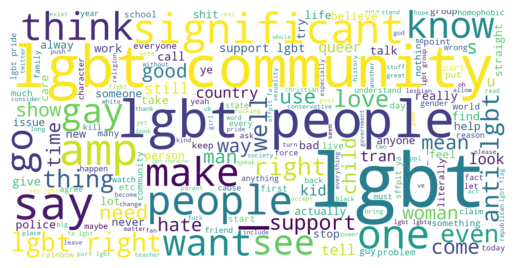

In [24]:
# Plotting the Word Cloud
words = ' '.join([tweets for tweets in df_data['tweet']])
wordcloud = WordCloud(width=2000, height=1000, random_state=21, background_color='white', max_font_size=300 ).generate(words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [25]:
# Function to find negative, neutral and positive tweets
def polarity(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

df_data['Sentiment'] = df_data['Polarity'].apply(polarity)

df_data

,tweet,Subjectivity,Polarity,Sentiment
0,pray lgbt nigerians folded_hands_medium_skin_t...,0.000000,0.000000,Neutral
1,pass agg oh god ( oh gosh ) really lgbt,0.200000,0.200000,Positive
2,"_ 56ol many work medium , twitter fb seem prob...",0.758929,0.258929,Positive
3,clear justify lgbt community behavior obviousl...,0.689583,0.143750,Positive
4,good night lgbt community,0.600000,0.700000,Positive
...,...,...,...,...
32451,l pedos w lgbt+ community,0.000000,0.000000,Neutral
32452,i`m anti - trans anti - lgbt,0.000000,0.000000,Neutral
32453,lgbt lgbtq lgbtqiaplus lgbtqcommunity lgbtqia ...,0.737500,-0.012500,Negative
32454,man fucking wonder significant hard many usrai...,0.724074,0.120370,Positive


In [26]:
# Finding all positive tweets
q=1
data_sorted = df_data.sort_values(by=['Polarity'])
for l in range(0, data_sorted.shape[0]):
  if(data_sorted['Sentiment'][l] == 'Positive'):
    (str(q) + ') ' + data_sorted['tweet'][l])
    q = q+1

In [27]:
# Finding all negative tweets
q=1
data_sorted = df_data.sort_values(by=['Polarity'], ascending=False)
for l in range(0, data_sorted.shape[0]):
  if(data_sorted['Sentiment'][l] == 'Negative'):
    (str(q) + ') ' + data_sorted['tweet'][l])
    q = q+1

In [29]:
# Finding all neutral tweets
q=1
data_sorted = df_data.sort_values(by=['Polarity'], ascending=False)
for l in range(0, data_sorted.shape[0]):
  if(data_sorted['Sentiment'][l] == 'Neutral'):
    (str(q) + ') ' + data_sorted['tweet'][l])
    q = q+1

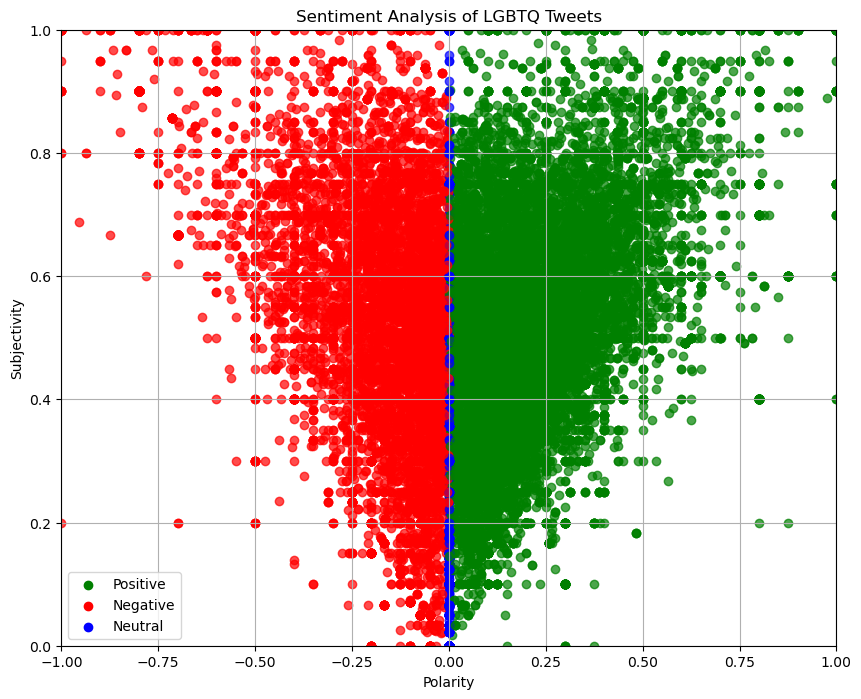

In [31]:
## Displaying Polarity and Subjectivity
plt.figure(figsize=(10, 8))

color_map = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}

# Iterate through data and plot points with different colors
for index, row in df_data.iterrows():
    plt.scatter(row['Polarity'], row['Subjectivity'], color=color_map[row['Sentiment']], alpha=0.7)

for sentiment, color in color_map.items():
    plt.scatter([], [], color=color, label=sentiment)
plt.legend()

plt.title('Sentiment Analysis of LGBTQ Tweets')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

# Adding grid lines
plt.grid(True)

plt.xlim(-1, 1)  
plt.ylim(0, 1)   


plt.show()


Percentage of Postive Tweets on LGBTQ are  49.8
Percentage of Negative Tweets on LGBTQ are  24.5
Percentage of Neutral Tweets on LGBTQ are  25.7


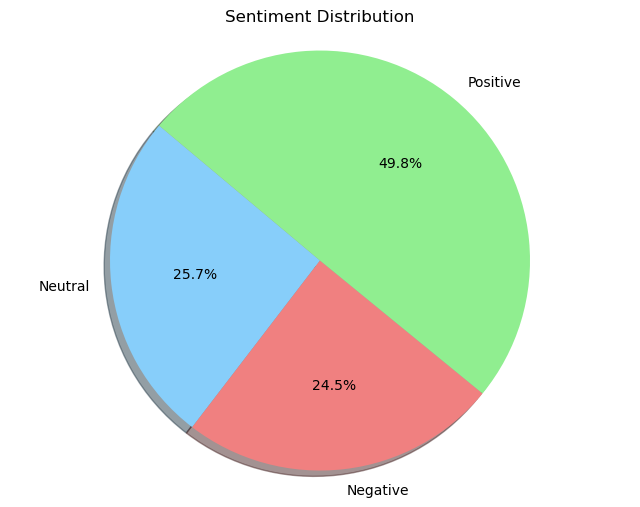

In [51]:
# Getting percentage of Sentiments

# positive tweets
pos_tweets = df_data[df_data.Sentiment == 'Positive']
pos_tweets = pos_tweets['tweet']

pos_percent = round( (pos_tweets.shape[0] / df_data.shape[0]) * 100, 1)
print("Percentage of Postive Tweets on LGBTQ are ", pos_percent)

# negative tweets
neg_tweets = df_data[df_data.Sentiment == 'Negative']
neg_tweets = neg_tweets['tweet']

neg_percent = round( (neg_tweets.shape[0] / df_data.shape[0]) * 100, 1)
print("Percentage of Negative Tweets on LGBTQ are ", neg_percent)

# neutral tweets
neu_tweets = df_data[df_data.Sentiment == 'Neutral']
neu_tweets = neu_tweets['tweet']

neu_percent = round( (neu_tweets.shape[0] / df_data.shape[0]) * 100, 1)
print("Percentage of Neutral Tweets on LGBTQ are ", neu_percent)

# Data for the pie chart
labels = ['Neutral', 'Negative', 'Positive']
sizes = [neu_percent, neg_percent, pos_percent]
colors = ['lightskyblue', 'lightcoral', 'lightgreen']
explode = (0, 0, 0)  # Explode the first slice (Neutral) for emphasis

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.title('Sentiment Distribution')
plt.show()


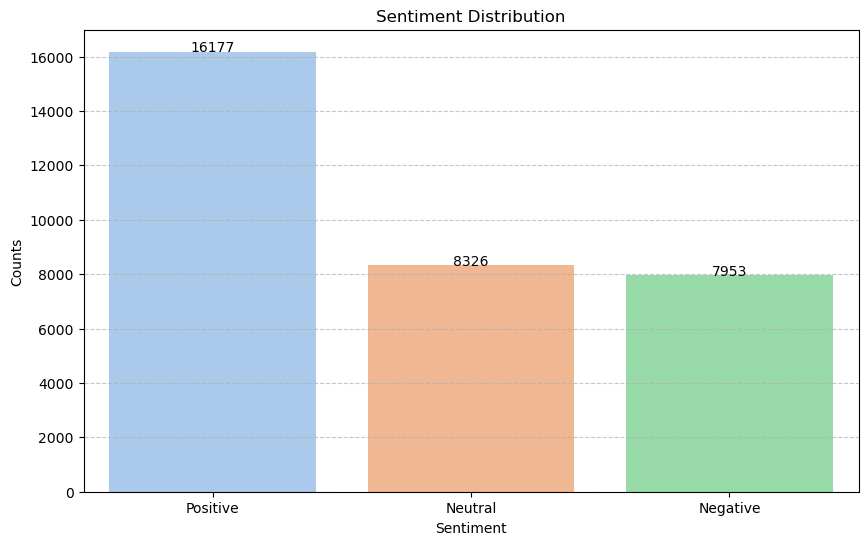

In [52]:
# Get value counts of each sentiment category
sentiment_counts = df_data['Sentiment'].value_counts()

plt.figure(figsize=(10, 6))
sns.set_palette("pastel")  # Using a pastel color palette
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# Adding labels and title
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Counts')

# Adding data labels on top of the bars
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value + 10, str(value), ha='center')

# Adding a background grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


In [43]:
# Tokenize and preprocess documents
df_data["tweets_tokenise"] = df_data["tweet"].apply(word_tokenize)

# Using basic string splitting
df_data["tweets_tokenise"] = df_data["tweet"].str.split()


# Count word occurrences across all documents
all_words = [word for doc in df_data['tweets_tokenise'] for word in doc]
word_counts = Counter(all_words)

# Print the top 10 most occurring words
top_words = [(word, count) for word, count in word_counts.most_common(50) if word.isalpha()]
print("Top 30 most occurring words:")
for word, count in top_words:
    if word.isalpha():
        print(f"{word}: {count} occurrences")


df = pd.DataFrame(top_words)

Top 30 most occurring words:
lgbt: 30501 occurrences
people: 7329 occurrences
community: 4480 occurrences
like: 4169 occurrences
right: 3590 occurrences
gay: 3290 occurrences
say: 3083 occurrences
significant: 2699 occurrences
get: 2542 occurrences
make: 2394 occurrences
amp: 2280 occurrences
go: 2157 occurrences
one: 2140 occurrences
would: 1994 occurrences
think: 1985 occurrences
want: 1964 occurrences
know: 1907 occurrences
support: 1897 occurrences
see: 1781 occurrences
woman: 1744 occurrences
anti: 1697 occurrences
man: 1581 occurrences
also: 1494 occurrences
sffpit: 1474 occurrences
love: 1405 occurrences
thing: 1402 occurrences
hate: 1395 occurrences
pride: 1389 occurrences
even: 1374 occurrences
come: 1228 occurrences
good: 1202 occurrences
group: 1200 occurrences
need: 1179 occurrences


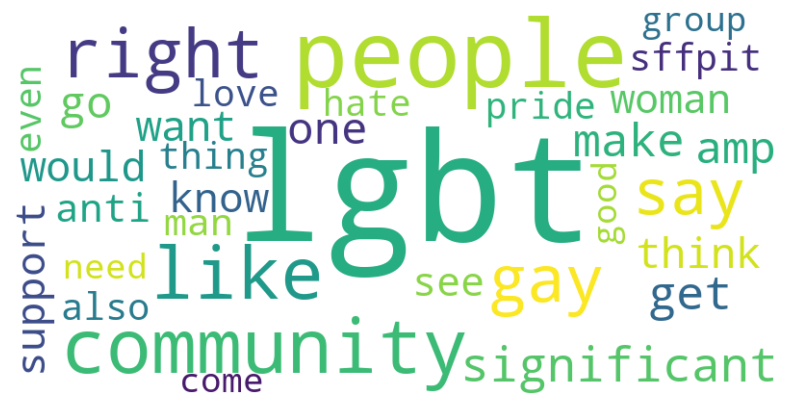

In [50]:
# Create a WordCloud instance
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(df[0], df[1])))

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


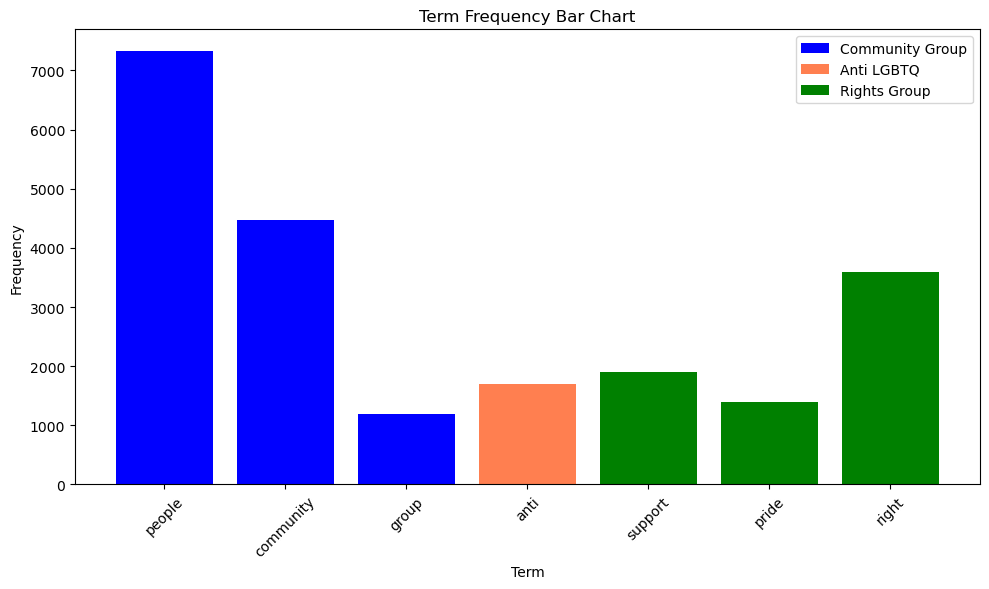

In [2]:
#Bar Graph for most occuring terms
data = {
    "term": ["people", "community", "group", "anti", "support", "pride", "right"],
    "frequency": [7329, 4480, 1200,1697, 1897, 1389, 3590]  # Replace with actual term frequencies
}
df = pd.DataFrame(data)


color_group1 = 'blue'
color_group2 = 'green'
color_special = 'coral'

# Create a bar chart
plt.figure(figsize=(10, 6))

plt.bar(df["term"][:3], df["frequency"][:3], color=color_group1, label='Community Group')

plt.bar(df["term"][3:4], df["frequency"][3:4], color=color_special, label='Anti LGBTQ')

plt.bar(df["term"][4:], df["frequency"][4:], color=color_group2, label='Rights Group')

plt.xlabel("Term")
plt.ylabel("Frequency")
plt.title("Term Frequency Bar Chart")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Add a legend
plt.tight_layout()  # Ensure labels fit within the figure
plt.show()
